# Non-Stationary Contextual Bandits Evaluation

In this notebook we will build a simple setting (contextual bandits) to understand how a non-stationary policy should be evaluated. 

#### Contextual bandits
We introduce a contextual bandit with 2 arms, where the choice of its actions $a_t\in\{0,1\}$ also depends on its context $x_t$, which is sampled from a Context distribution $\mathcal{D}$.
Moreover, at each time $t$ the policy parameter will be given by a time-dependent hyperpolicy $\nu$ that is tuned with the hyperparameters $\rho$.

#### Problem definition 
The environment will be defined by a sinusoidal non-stat process. In order to handle the non-stationary process, the hyperpolicy needs to be based on a similar sinusoidal process, and its goal should be learning and replicating the non-stationary process (thus $\theta_t \simeq \mu(t)= A\sin(\phi t + \psi)$) in order to maximize the rewards. We can choose two different problems:

 - **Non-stationary Context distribution** (for `NS_context=True`): Context will be sampled from a time-dependent context distribution with mean $\mu(t)$ and fixed $\sigma_x$. In this case the bandit has to recognises if $x_t-\mu(t)<0$ (corresponding to $a_t=0$) or if $x_t-\mu(t)>0$ (corresponding to $a_t=1$). The reward is sampled from a Bernoulli distr with param $p_{env} = \text{sigmoid}(x_t-\mu(t))$ if agent chooses $a_t=1$ and with param $1-p_{env}$ if $a_t=0$.

 - **Non-stationary Reward function** (for `NS_context=False`): Context will be sampled from a fixed distribution $\mathcal{N}(0,\sigma_x)$, and the non-stationary process appears in the reward distributions, which will also depend on the sampled contexts. The reward is sampled from a Bernoulli distr with param $p_{env} = \text{sigmoid}(x_t+\mu(t))$ if agent chooses $a_t=1$ and with param $1-p_{env}$ if $a_t=0$. In this case the bandit has to recognise if $x_t+\mu_r(t)\lessgtr0$ (therefore the policies will be slightly different from the previous case, but the hyperpolicy don't change).
 

In the end, the bandit can be represented in two ways, depending on the approach defined by the flag `param_based`:
 - **Action-based exploration**: The stochasticity is given by the policy, which will be represented by a Bernoulli distribution $\pi_{\theta_t}(a_t|x_t) = \left(1-p_a, p_a\right)$, where $p_a \equiv f(\theta_t, x_t) = \text{sigmoid}(x_t\pm\theta_t)$ (depending on `NS_context`) and $\theta_t \sim \nu_\rho(\theta_t|t)$. In this case, the hyperpolicy is deterministic and, at each $t$, the value of $\theta_t$ is given by $\theta_t = \nu_\rho(t) = A_\theta\sin(\phi_\theta t + \psi_\theta)$.
 
 - **Parameter-based exploration**: The stochasticity is given by the hyperpolicy, which is represented by a time-dependent gaussian distribution $\nu_\rho(\theta_t|t) = \mathcal{N}(\mu_\theta(t),\sigma_\theta)$ with $\mu_\theta(t) = A_\theta\sin(\phi_\theta t + \psi_\theta)$ and a constant $\sigma_\theta$. The sampled $\theta_t$ will now define a deterministic policy $\pi_{\theta_t}(x_t)$, which will be represented by a step function centered in $(x_t\pm\theta_t)$ (depending on `NS_context`)

In [1]:
# Import libraries
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

## Environment definition

In [2]:
class environment:
    
    ### Define the environment: NS_context=True  -> non-stat context distribution    
    ###                         NS_context=False -> non-stat reward function
    ###                         remove_contexts -> x_t=0 always, reward function becomes non-stat
    def __init__(self, NS_context, remove_context=False, sigma_x=1, t0=0, **kwargs):
        
        # Store the given parameters
        self.t = t0
        self.sigma_x = sigma_x
        self.remove_context = remove_context
        
        # If we don't want to use context, use a non-stat reward function
        if remove_context:
            self.NS_context = False
        else:
            self.NS_context = NS_context
        
        # if params that define the mean are not given, take random ones
        self.var_names = ['A', 'phi', 'psi'] 
        for var in self.var_names:
            if var in kwargs.keys():
                setattr(self, var, kwargs[var])
            else:
                setattr(self, var, np.random.rand())
    

    
    ### Definition of the non-stationary process: 
    ###    If NS_context = True,  it defines the mean of the context distribution
    ###    If NS_context = False, it defines a term in the reward function
    def non_stat_process(self, t):
        return self.A * np.sin(self.phi*t + self.psi)
        
    
    
    ### Compute the context mean at present timestep 'self.t'. If context distr is 
    ### stationary or if x_t is fixed to 0, the mean is always equal to 0
    def x_mean(self, t=None):
        if self.remove_context or not(self.NS_context):
            return 0
        else:
            return self.non_stat_process(self.t)

        
    ### Sample a context from the distibution at time 'self.t'
    def sample_x(self):
        if self.remove_context:
            return 0
        else:
            return scipy.stats.norm.rvs(loc   = self.x_mean(), 
                                        scale = self.sigma_x)
    
    
    
    
    ### Sample reward from a Bernoulli distribution that depends on the action and the context; 
    ### The parameter is computed differently if we have non-stat contexts or non-stat rewards
    def get_reward(self, x, action, get_p=False):
        
        # Compute bernoulli parameter for the correct case
        if self.NS_context:
            p_t = sigmoid( x - self.x_mean() )
        else:
            #initial_reward = self.non_stat_process(self.t)                  #      ----  ATTENTION  ----
            #p_t = sigmoid( x + initial_reward )
            p_t = self.non_stat_process(self.t) + 0.5
        
        # If we want to study the distributions, return parameter instead of reward
        if get_p:
            if action:
                return p_t
            else:
                return 1-p_t
        
        # Sample a reward given the chosen action
        if action:
            return scipy.stats.bernoulli.rvs(p_t)
        else:
            return scipy.stats.bernoulli.rvs(1 - p_t)
            
            
    
    
    ### Use the hyperpolicy nu to perform many subsequent steps
    ### Returns the evolution of many variables
    def play(self, nu, n_steps, get_p=False):
        
        contexts = np.array([])
        thetas   = np.array([])
        rewards  = np.array([])
        actions  = np.array([])
        non_stat_process = np.array([])
        theta_means      = np.array([])
    
        # At each timestep...
        for i in range(n_steps):
            
            # Sample a policy from the hyperpolicy 
            # (given t and the tipe of non-stationarity)
            policy = nu.sample_policy(self.t, self.NS_context)
            
            # Sample a context from the corresponding distribution
            x_t = self.sample_x()
            
            # Perform a step sampling the action from current policy 
            action = policy.action(x_t)
            reward = self.get_reward(x_t, action, get_p)
            
            # Store current values in the arrays
            contexts = np.append(contexts, x_t)
            thetas   = np.append(thetas, policy.theta)
            rewards  = np.append(rewards, reward)
            actions  = np.append(actions, action)
            non_stat_process = np.append(non_stat_process, self.non_stat_process(self.t))
            theta_means   = np.append(theta_means, nu.theta_mean(self.t))
            
            # Update time variable
            self.t += 1

        return contexts, thetas, rewards, actions, non_stat_process, theta_means
    
    def play_deter(self, nu, n_steps, get_p=False):
        
        contexts = np.array([])
        thetas   = np.array([])
        rewards  = np.array([])
        actions  = np.array([])
        non_stat_process = np.array([])
        theta_means      = np.array([])
    
        # At each timestep...
        for i in range(n_steps):
            
            # Sample a policy from the hyperpolicy 
            # (given t and the tipe of non-stationarity)
            policy = policy_class(nu.theta_mean(self.t), self.NS_context, False)
            
            # Sample a context from the corresponding distribution
            x_t = self.sample_x()
            
            # Perform a step sampling the action from current policy 
            action = policy.action(x_t)
            reward = self.get_reward(x_t, action, get_p)
            
            # Store current values in the arrays
            contexts = np.append(contexts, x_t)
            thetas   = np.append(thetas, policy.theta)
            rewards  = np.append(rewards, reward)
            actions  = np.append(actions, action)
            non_stat_process = np.append(non_stat_process, self.non_stat_process(self.t))
            theta_means   = np.append(theta_means, nu.theta_mean(self.t))
            
            # Update time variable
            self.t += 1

        return contexts, thetas, rewards, actions, non_stat_process, theta_means
    
        

## Policy definition

Here we will define the policy class following the structure described at the beginning of the notebook. The action is given by a bool variable. If `stochastic = True`, the policy sample the action from the Bernoulli distribution, otherwise the policy is just a step function.

In [3]:
class policy_class:
    
    ### Theta is the only param and reprsents an estimate of the non-stat 
    ### process of the environment (that represent different )
    def __init__(self, theta, NS_context, stochastic=True):
        self.theta = theta
        self.stochastic = stochastic
        self.NS_context = NS_context
    
    ### Return the bernoulli distr over the actions given the context
    ### (makes sense only if policy is stochastic, i.e. action-based case)
    def bernoulli_distr(self, x):
        if self.NS_context:
            p = sigmoid(x - self.theta)
        else:
            p = sigmoid(x + self.theta)
        return (1-p,p)
        
     
    ### Choose action given the sampled context (and depending on the problem)
    def action(self, x):
        
        ### IF env has nonstationary Context distribution,
        ### action = 1 has higher prob (or chosen) if x-theta > 0
        if self.NS_context:
            if self.stochastic:
                p = sigmoid(x - self.theta)
                return scipy.stats.bernoulli.rvs(p)
            else:
                return (x - self.theta > 0)
            
        ### IF env has nonstationary reward function,
        ### action = 1 has higher prob (or chosen) if x+theta > 0
        else:
            if self.stochastic:
                p = sigmoid(x + self.theta)
                return scipy.stats.bernoulli.rvs(p)
            else:
                return (x + self.theta > 0)

## Hyperpolicy definition

Here we will define the hyperpolicy class following the structure described at the beginning of the notebook. If `param_based = True`, the hyperpolicy will be stochastic and will sample the $\theta_t$ value from the gaussian distribution with a time dependent mean $\mu_\theta(t)$, otherwise we just have $\theta_t = \mu_\theta(t)$.

In [4]:
class hyperpolicy:
        
    def __init__(self, param_based=True, sigma_theta=1, **kwargs):
        
        # Store the given parameters
        self.sigma_theta = sigma_theta
        self.stochastic = param_based
        
        # if params that define the mean are not given, take random ones        
        self.var_names = ['A', 'phi', 'psi'] 
        for var in self.var_names:
            if var in kwargs.keys():
                setattr(self, var, kwargs[var])
            else:
                setattr(self, var, np.random.rand())
               
            
    
    def theta_mean(self, t):
        return self.A * np.sin(self.phi*t + self.psi)
    
        
    def theta_pdf(self, theta, t):
        return scipy.stats.norm.pdf(theta, loc=self.theta_mean(t), scale=self.sigma_theta)
    
    
    def sample_theta(self, t):
        if self.stochastic:
            return scipy.stats.norm.rvs(loc=self.theta_mean(t), scale=self.sigma_theta)
        else:
            return self.theta_mean(t)

    def sample_policy(self, t, NS_context):
        theta = self.sample_theta(t)
        return policy_class(theta, NS_context, not(self.stochastic) )
    
    
    #def update_params(self, delta_params):
        
        # TO DO
        

# Test environment

Tune the problem changing:
 - `param_based`: Look beginning of the notebook
 - `NS_context`:  Look beginning of the notebook
 - `remove_context`: If True, the context will be always equal to zero. In this case the problem is forced to have a non-stationary reward function.
 - `get_p`: Set to `True` if you want to study the reward process: the `env.play()` method will not return the collected reward at each step, but it will return the bernoulli parameters $p_t$ that define the distributions over the rewards at each step.

In [5]:

#### Problem settings ####
param_based = True
NS_context  = False
remove_context = True
get_p = True
##########################


# Get random hyperpolicy
nu  = hyperpolicy(param_based, sigma_theta=1,
                  A=5, phi=0.1, psi=np.pi)



# Initialize environment and the type of problem
env = environment(NS_context, remove_context, sigma_x=2, 
                  A=0.5, phi=0.1, psi=np.pi)

# Play the hyperpolicy
contexts, thetas, rewards, actions, NS_process, theta_means = env.play(nu, n_steps=250, get_p=get_p)
contexts_deter, thetas_deter, rewards_deter, actions_deter, NS_process_deter, theta_means_deter = env.play_deter(nu, n_steps=350, get_p=get_p)

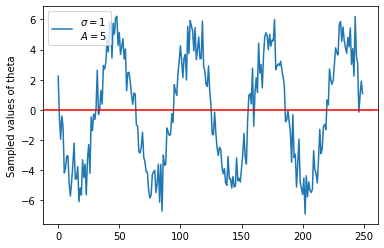

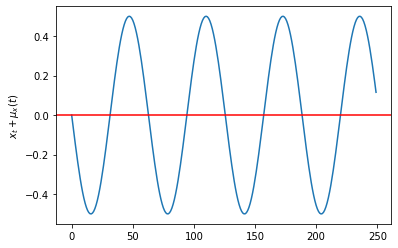

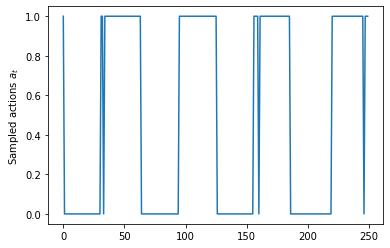

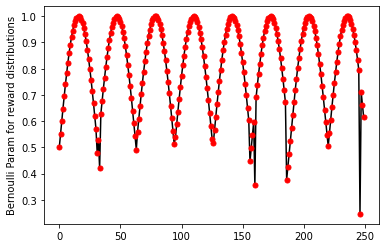

In [6]:
### Plot the evolution of everything
"""
plt.plot(NS_process, label="Non-Stat process")
plt.plot(theta_means, label="Theta mean`")
plt.ylabel("Means of the hyperpolicy and context distributions")
plt.legend()
plt.show()
"""

plt.plot(thetas, label='$\sigma=1$\n$A=5$')
plt.ylabel("Sampled values of theta")
plt.axhline(y=0, c='r')
plt.legend()
plt.show()


if remove_context or not(NS_context):
    plt.plot(contexts + NS_process)
    plt.ylabel('$x_t + \mu_x(t)$')
else:
    plt.plot(contexts - NS_process)
    plt.ylabel('$x_t - \mu_x(t)$')
plt.axhline(y=0, c='r')
plt.show()


plt.plot(actions)
plt.ylabel('Sampled actions $a_t$')
plt.show()


plt.plot(rewards, c='black')
plt.plot(np.where(rewards>0)[0],  rewards[rewards>0],  'ro', markersize=5)
plt.plot(np.where(rewards==0)[0], rewards[rewards==0], 'bo', markersize=5)
if get_p: 
    plt.ylabel('Bernoulli Param for reward distributions')
else:
    plt.ylabel('Sampled rewards')
plt.show()

# MIS Performance Estimator
### *The estimator is built assuming that we are using a parameter-based approach, so it should be used only in this setting. Nevertheless it is possible to try it with action-based to study its properties (no stochastisicy in the choice of theta) -> theta determined deterministically, but the IS weights still consider the hyperpolicy a distribution*

The quantity that we wish to estimate and maximize is the following
$$J=\mathbb{E}_{\nu_\rho(\cdot\vert t+1)} \left[\left. \sum_{i=t+1}^{\infty} \gamma^i R_i \right\vert s_t \right]$$

So, at each timestep, We use the non-stationary policy to estimate the performance of the policy at time $t+1$. We regularize by using importance sampling and, to be specific, we will use MIS-based estimators because the hyperpolicy $\nu_\rho(t)$ changes at each timestep. The "plain" MIS estimator is
$$ \hat{J}=\frac{1}{\alpha}\sum_{i=t-\alpha}^{t}R_i \frac{\nu_\rho(\theta_i\vert t+1)}{\nu_\rho(\theta_i\vert i)} $$

This default version of the estimator is given by having `beta=1`, but different values of beta could be set. In this case the MIS estimator has the following form:
$$ \hat{J} = C_\beta \sum_{i=t-\alpha}^{t} \beta^{t-i} R_i \frac{\nu_\rho(\theta_i\vert t+1)}{\nu_\rho(\theta_i\vert i)}$$
where $C_\beta=\frac{1-\beta}{1-\beta^{\alpha-1}}$ is the normalization constant.

To test the estimator, `return_type=0` will return the estimated performance, `return_type=1` will return the weigthed rewards, and `return_type=2` will just return the Importance Sampling weights that multipy each reward.

In [7]:
def MIS_estimator(nu, thetas, rewards, t, return_type=0, beta=1):
    
    # Check if rewards and thetas have the same lenght
    assert len(thetas) == len(rewards), "Thetas and rewards have different lengths"
#     if len(thetas) != len(rewards):
#         print("\n ----- Thetas and rewards have different lengths ----- \n")
#         return None

    # Compute time of past rewards and prepare array for them
    t0 = (t+1) - len(rewards)
    timesteps = np.arange(t0, t+1)
    sum_terms = np.array([]) 
    
    # Compute constant normalization term (for beta<1)
    if beta<1:
        beta_normalization = (1-beta)/(1-beta**(len(rewards)-1))
        
    # Compute the weighted rewards inside the time window (with lenght alpha)
    for i in timesteps:
        
        # Compute importance weight given the type of the estimator (with beta ir not)
        IS_weight = nu.theta_pdf(thetas[i-t0], t+1) / nu.theta_pdf(thetas[i-t0], i)
        if beta == 1:
            IS_weight = IS_weight / len(rewards)
        else:
            IS_weight = IS_weight * beta_normalization * beta**(t-i)
        
        # IF we are interested in the weights, don't compute weighted rewards
        if return_type == 2:
            sum_terms = np.append(sum_terms, IS_weight)
        else:
            IS_reward = rewards[i-t0] * IS_weight
            sum_terms = np.append(sum_terms, IS_reward)
    
    # If we are interested in just the estimated performance, sum the weighted rewards
    if return_type == 0:
        return np.sum(sum_terms)
    else:
        return sum_terms

## Test Performance Estimator
Study the behaviour of the different terms of the MIS estimator on the last timestep using every collected reward and policy (i.e. with $\alpha=t$)

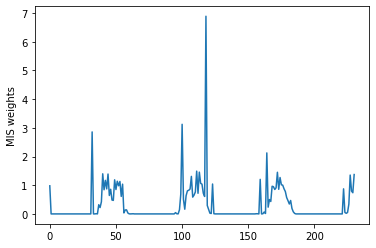

In [8]:
### Study the behaviour of the different terms of the MIS estimator on the last
### timestep using the all the collected rewards and policies (i.e. alpha=t)

# MIS estimator using all the available data
t = len(rewards)-20
MIS_terms = MIS_estimator(nu, thetas[:t+1], rewards[:t+1], t, return_type=2, beta=1)

# Plot the terms to see how they impact the performance estimation
plt.plot(MIS_terms*t)
plt.ylabel("MIS weights")
plt.show()

Now, use the estimator with a smaller value of $\alpha$ to measure the performance of the hyperpolicy at time $t+1$ for each each time $t\in[T-\alpha,T]$ ($T$ is the lenght of the dataset)

100%|██████████| 121/121 [00:11<00:00, 10.58it/s]


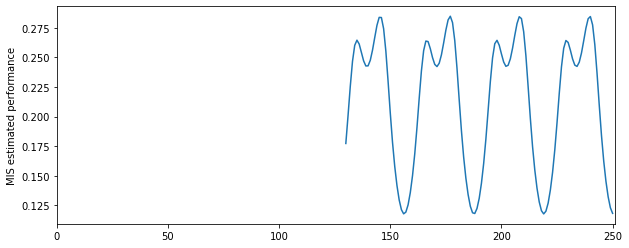

In [9]:
# Prepare array to contain estimated performances
alpha = 130
performances = np.array([])

# Compute performances
for t in tqdm(range(alpha, len(rewards)+1)):
    MIS_performance = MIS_estimator(nu, thetas_deter[t-alpha:t+1], rewards_deter[t-alpha:t+1], t, beta=1)
    performances = np.append(performances, MIS_performance)
    
# Plot the perfromances as function of time
plt.figure(figsize=[10,4])
plt.plot(np.arange(alpha, len(rewards)+1), performances)
plt.ylabel("MIS estimated performance")
plt.xlim(0, len(rewards)+1)
#plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))
plt.show()

After some tests, it is possible to see that different values of $\alpha$ will lead to very different performance estimations over time, even if the collected data is the same. Let's study this behaviour and estimate the future performance with a variable $\alpha$

100%|██████████| 248/248 [00:21<00:00, 11.29it/s]


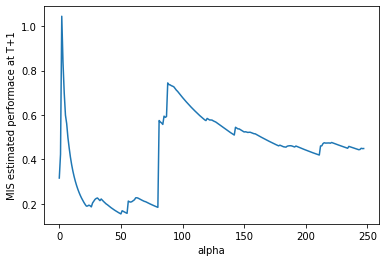

In [11]:
# Prepare array to contain estimated performances
performances = np.array([])
t = len(rewards)

# Compute performances
for alpha in tqdm(range(2,len(rewards))):
    MIS_performance = MIS_estimator(nu, thetas[t-alpha:t+1], rewards[t-alpha:t+1], t, beta=1)
    performances = np.append(performances, MIS_performance)
    
# Plot the performance at t+1 as function of alpha
plt.plot(performances)
plt.xlabel("alpha")
plt.ylabel("MIS estimated performace at T+1")
plt.show()

It is possible to see that having $\beta<1$ highly reduce the dependency of the performance estimator on $\alpha$, meaning that different value of $\alpha$ will return the same estimated performance given the sampled policies and rewards. This is very important for us, because it allows us to estimate performance in a scenario where the period of the non-stat process is not known.

### Test robustness of estimator with/without beta
We will now see how beta makes the performances estimates more robust wrt the choice of $\alpha$

100%|██████████| 248/248 [00:45<00:00,  5.42it/s]


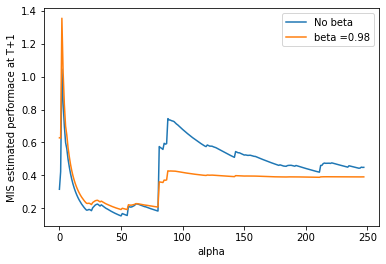

100%|██████████| 111/111 [00:20<00:00,  5.38it/s]


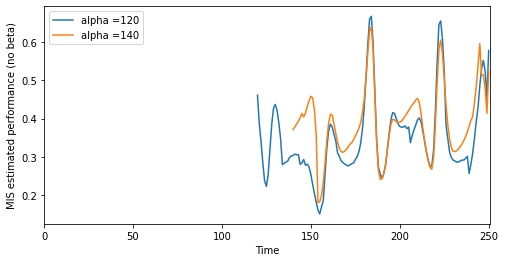

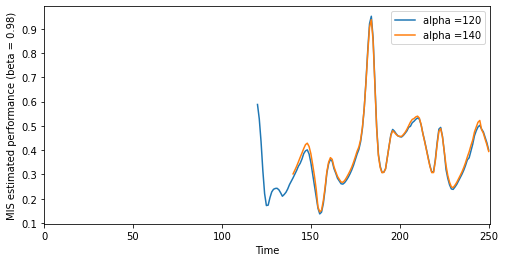

In [12]:
### First compute the performance at time T+1 as
### function of alpha (with and without beta)

beta = 0.98

# Prepare array to contain estimated performances
performances_alpha = np.array([]).reshape(0,2)
t = len(rewards)

# Compute performances as function of alpha
for alpha in tqdm(range(2,len(rewards))):
    no_beta_performance = MIS_estimator(nu, thetas[t-alpha:t+1], rewards[t-alpha:t+1], t)
    beta_performance    = MIS_estimator(nu, thetas[t-alpha:t+1], rewards[t-alpha:t+1], t, beta=beta)
    performances_alpha  = np.append(performances_alpha, [[no_beta_performance, beta_performance]], axis = 0)

# Plot the performances at t+1 as function of alpha
plt.plot(performances_alpha[:,0], label='No beta')
plt.plot(performances_alpha[:,1], label='beta ='+str(beta))
plt.xlabel("alpha")
plt.ylabel("MIS estimated performace at T+1")
plt.legend()
plt.show()
    
    
    
    
### Now compute performances for each t with 2 different
### values of alpha in the case with beta = 0.98 and no beta

# Prepare array to contain estimated performances
alpha_1 = 120
alpha_2 = 140
performances_1 = np.array([]).reshape(0,2)
performances_2 = np.array([]).reshape(0,2)


# Compute performances with the first value of alpha
for t in tqdm(range(alpha_1, len(rewards)+1)):
    no_beta_performance = MIS_estimator(nu, thetas[t-alpha_1:t+1], rewards[t-alpha_1:t+1], t)
    beta_performance = MIS_estimator(nu, thetas[t-alpha_1:t+1], rewards[t-alpha_1:t+1], t, beta=beta)
    performances_1 = np.append(performances_1, [[no_beta_performance, beta_performance]], axis = 0)
    
# Compute performances with the second value of alpha
for t in tqdm(range(alpha_2, len(rewards)+1)):
    no_beta_performance = MIS_estimator(nu, thetas[t-alpha_2:t+1], rewards[t-alpha_2:t+1], t)
    beta_performance = MIS_estimator(nu, thetas[t-alpha_2:t+1], rewards[t-alpha_2:t+1], t, beta=beta)
    performances_2 = np.append(performances_2, [[no_beta_performance, beta_performance]], axis = 0)



### Plot results
x_points_1 = np.arange(alpha_1, len(rewards)+1)
x_points_2 = np.arange(alpha_2, len(rewards)+1)
    
# Plot the performances without beta as function of time
plt.figure(figsize=[8,4])
plt.plot(x_points_1, performances_1[:,0], label='alpha ='+str(alpha_1))
plt.plot(x_points_2, performances_2[:,0], label='alpha ='+str(alpha_2))
plt.ylabel("MIS estimated performance (no beta)")
plt.xlabel("Time")
plt.xlim(0, len(rewards)+1)
plt.legend()
plt.show()

# Plot the performances with beta as function of time
plt.figure(figsize=[8,4])
plt.plot(x_points_1, performances_1[:,1], label='alpha ='+str(alpha_1))
plt.plot(x_points_2, performances_2[:,1], label='alpha ='+str(alpha_2))
plt.ylabel("MIS estimated performance (beta = 0.98)")
plt.xlabel("Time")
plt.xlim(0, len(rewards)+1)
plt.legend()
plt.show()

In [13]:
def MIS_estimator_other(nu, thetas, rewards, alpha=10, beta=1):
    
    # Check if rewards and thetas have the same lenght
    assert len(thetas) == len(rewards), "Thetas and rewards have different lengths"
    assert len(thetas) > alpha, "Not enough data for the estimator"

    # Compute time of past rewards and prepare array for them
    t = len(thetas)
    timesteps = np.arange(t-alpha, t)
    IS_est = []
    
    # Compute constant normalization term (for beta<1)
    if beta<1:
        beta_normalization = np.array([beta**(t-i) for i in timesteps])
        beta_normalization *= (1-beta)/(1-beta**(len(rewards)-1))
    else: 
        beta_normalization = 1/alpha
        
        
    # Compute the weighted rewards inside the time window (with lenght alpha)
    IS_weights = np.array([nu.theta_pdf(thetas[i], t) / nu.theta_pdf(thetas[i], i) for i in timesteps])
    IS_est  = beta_normalization * IS_weights * rewards[timesteps]

    return IS_est, np.sum(IS_est), IS_weights#, rewards[timesteps], beta_normalization

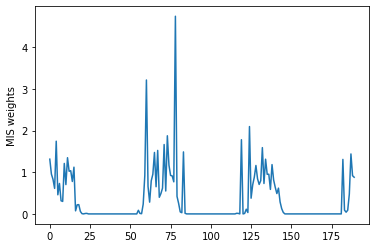

In [14]:
time_of_est = len(thetas)-20

MIS_terms, MIS_est, IS_weights = MIS_estimator_other(nu, thetas[:time_of_est], rewards[:time_of_est], alpha=190, beta=1)

# Plot the terms to see how they impact the performance estimation
plt.plot(IS_weights)
plt.ylabel("MIS weights")
plt.show()

In [15]:
alpha = 130
t_range = range(alpha+1,len(thetas))
MIS_through_time = [MIS_estimator_other(nu, thetas_deter[:i], rewards_deter[:i], alpha=alpha, beta=1)[1] for i in t_range]

In [16]:
wieghts_through_time = [MIS_estimator_other(nu, thetas_deter[:i], rewards_deter[:i], alpha=alpha, beta=1)[2] for i in t_range]

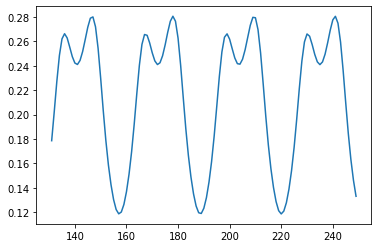

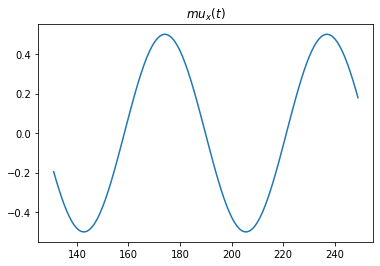

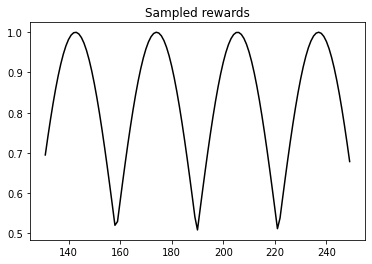

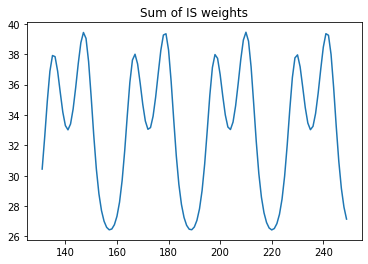

In [17]:
plt.plot(t_range, np.array(MIS_through_time))
plt.show()


plt.plot(t_range, NS_process_deter[t_range])
plt.title('$mu_x(t)$')
plt.show()


plt.plot(t_range, rewards_deter[t_range], c='black')
plt.title('Sampled rewards')
plt.show()


plt.plot(t_range, np.sum(np.array(wieghts_through_time),axis=1))
plt.title('Sum of IS weights')
plt.show()

In [20]:
alpha = 130
t_range = range(alpha+1,len(thetas))
MIS_through_time = [MIS_estimator_other(nu, thetas[:i], rewards[:i], alpha=alpha, beta=1)[1] for i in t_range]
wieghts_through_time = [MIS_estimator_other(nu, thetas[:i], rewards[:i], alpha=alpha, beta=1)[2] for i in t_range]

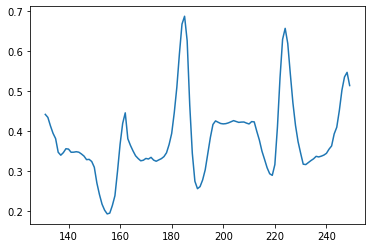

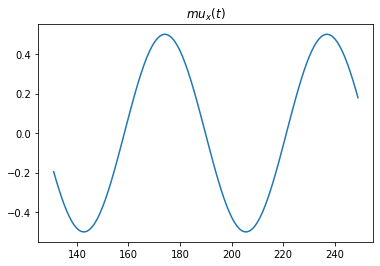

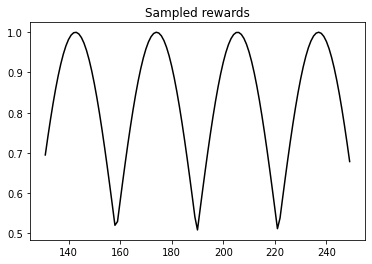

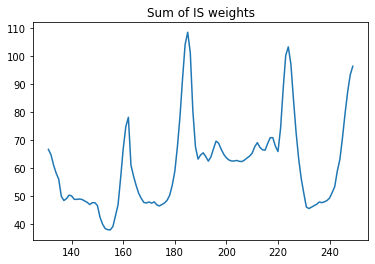

In [21]:
plt.plot(t_range, np.array(MIS_through_time))
plt.show()


plt.plot(t_range, NS_process_deter[t_range])
plt.title('$mu_x(t)$')
plt.show()


plt.plot(t_range, rewards_deter[t_range], c='black')
plt.title('Sampled rewards')
plt.show()


plt.plot(t_range, np.sum(np.array(wieghts_through_time),axis=1))
plt.title('Sum of IS weights')
plt.show()


### Evaluate average performance at T+1 as function of sigma_theta

In [89]:
#### Problem settings ####
param_based = True
NS_context  = False
remove_context = True
get_p = True
##########################

# Parameters
t = 236
alpha = 190
beta = 1
sigma_values = np.arange(0.25, 4 , 0.25)
A_sigma_ratio = 2
replicas = 50

performances = np.zeros((len(sigma_values),replicas))

# Compute performance "replica" times for each value of sigma
for i in range(len(sigma_values)):
    
    for j in range(replicas):    
        # Create new hyperpolicy and play it 
        A = sigma_values[i] * A_sigma_ratio
        nu  = hyperpolicy(param_based, A=A, phi=0.1, psi=np.pi, sigma_theta=sigma_values[i])
        env = environment(NS_context, remove_context, A=0.5, phi=0.1, psi=np.pi)
        contexts, thetas, rewards, actions, NS_process, theta_means = env.play(nu, n_steps=t, get_p=get_p)
        
        # Evaluate the performance 
        performances[i,j] = MIS_estimator_other(nu, thetas, rewards, alpha, beta)[1]

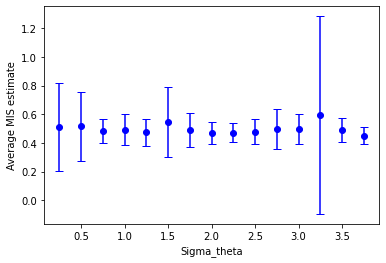

In [90]:
### Plot results
avg_estims = performances.mean(axis=1)
stds = performances.std(axis=1)
plt.errorbar(sigma_values, avg_estims, yerr=stds, fmt='bo', capsize=4)
plt.xlabel('Sigma_theta')
plt.ylabel('Average MIS estimate')
plt.show()

In [97]:
### Compute average IS weights (t=251 for 0, t=236 for max)
t = 236
alpha = 200
beta = 1
replicas = 50
all_IS_weights = np.zeros((replicas, alpha))

for i in range(replicas):    
    
    # Create new hyperpolicy and play it 
    nu  = hyperpolicy(param_based, A=9, phi=0.1, psi=np.pi, sigma_theta=3)
    env = environment(NS_context, remove_context, A=0.5, phi=0.1, psi=np.pi)
    contexts, thetas, rewards, actions, NS_process, theta_means = env.play(nu, n_steps=t, get_p=get_p)

    # Evaluate the performance 
    all_IS_weights[i] = MIS_estimator_other(nu, thetas, rewards, alpha, beta)[2]

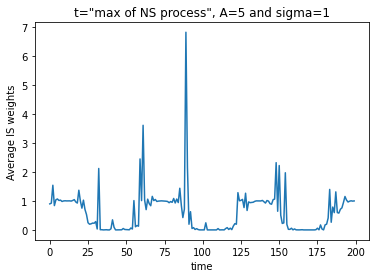

In [96]:
### Plot results
avg_estims = all_IS_weights.mean(axis=0)
plt.plot(avg_estims)
plt.xlabel('time')
plt.ylabel('Average IS weights')
plt.title('t="max of NS process", A=3 and sigma=1')
plt.show()

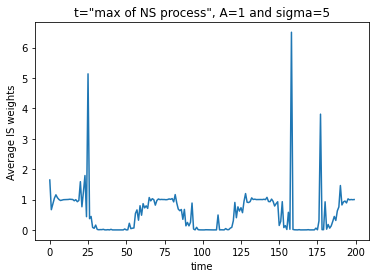

In [98]:
### Plot results
avg_estims = all_IS_weights.mean(axis=0)
plt.plot(avg_estims)
plt.xlabel('time')
plt.ylabel('Average IS weights')
plt.title('t="max of NS process", A=1 and sigma=5')
plt.show()

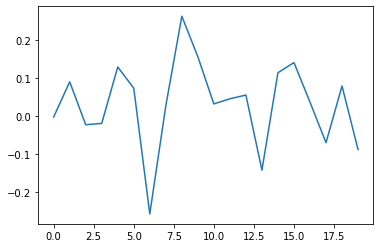

In [74]:
x1 = np.sin(np.arange(100) * 2*np.pi/100)
#sigma = np.linspace(0.1,1,20)
magnitudes = np.linspace(0.1,5,20)
diff = []

#for s in sigma:
for A in magnitudes:
    diff.append(np.mean([np.sum(A*x1+np.random.normal(0,s,100)) for seed in range(10000)]))

plt.plot(diff)

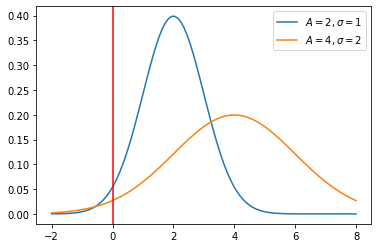

CDF in x=0 of first distr:  0.022750131948179195
CDF in x=0 of second distr: 0.022750131948179195


In [122]:
x = np.linspace(-2,8,100)
plt.plot(x, scipy.stats.norm.pdf(x, loc=2, scale=1), label='$A=2, \sigma=1$')
plt.plot(x, scipy.stats.norm.pdf(x, loc=4, scale=2), label='$A=4, \sigma=2$')
plt.axvline(x=0, c='r')
plt.legend()
plt.show()

print('CDF in x=0 of first distr: ', scipy.stats.norm.cdf(0, loc=2, scale=1))
print('CDF in x=0 of second distr:', scipy.stats.norm.cdf(0, loc=4, scale=2))

In [116]:
np.linspace(-1,8,100)

array([-1.        , -0.90909091, -0.81818182, -0.72727273, -0.63636364,
       -0.54545455, -0.45454545, -0.36363636, -0.27272727, -0.18181818,
       -0.09090909,  0.        ,  0.09090909,  0.18181818,  0.27272727,
        0.36363636,  0.45454545,  0.54545455,  0.63636364,  0.72727273,
        0.81818182,  0.90909091,  1.        ,  1.09090909,  1.18181818,
        1.27272727,  1.36363636,  1.45454545,  1.54545455,  1.63636364,
        1.72727273,  1.81818182,  1.90909091,  2.        ,  2.09090909,
        2.18181818,  2.27272727,  2.36363636,  2.45454545,  2.54545455,
        2.63636364,  2.72727273,  2.81818182,  2.90909091,  3.        ,
        3.09090909,  3.18181818,  3.27272727,  3.36363636,  3.45454545,
        3.54545455,  3.63636364,  3.72727273,  3.81818182,  3.90909091,
        4.        ,  4.09090909,  4.18181818,  4.27272727,  4.36363636,
        4.45454545,  4.54545455,  4.63636364,  4.72727273,  4.81818182,
        4.90909091,  5.        ,  5.09090909,  5.18181818,  5.27